### Customer Lifetime Value prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(filepath_or_buffer="./data/customer_segmentation.csv", encoding="cp1252") # Specify the encoding!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### Convert the date field

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#### Create a new field / feature from existing ones

In [4]:
# df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Revenue'] = df['UnitPrice'] * df['Quantity'] # This should be predicted!

In [5]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [6]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
count,541909.000000,541909,541909.000000,406829.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,17.987795
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,-168469.600000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,3.400000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,9.750000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,17.400000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,168469.600000
std,218.081158,NaN,96.759853,1713.600303,378.810824


In [7]:
# Grouping by 'Country' and counting unique 'InvoiceNo'
orders_per_country = df.groupby('Country')['InvoiceNo'].nunique()

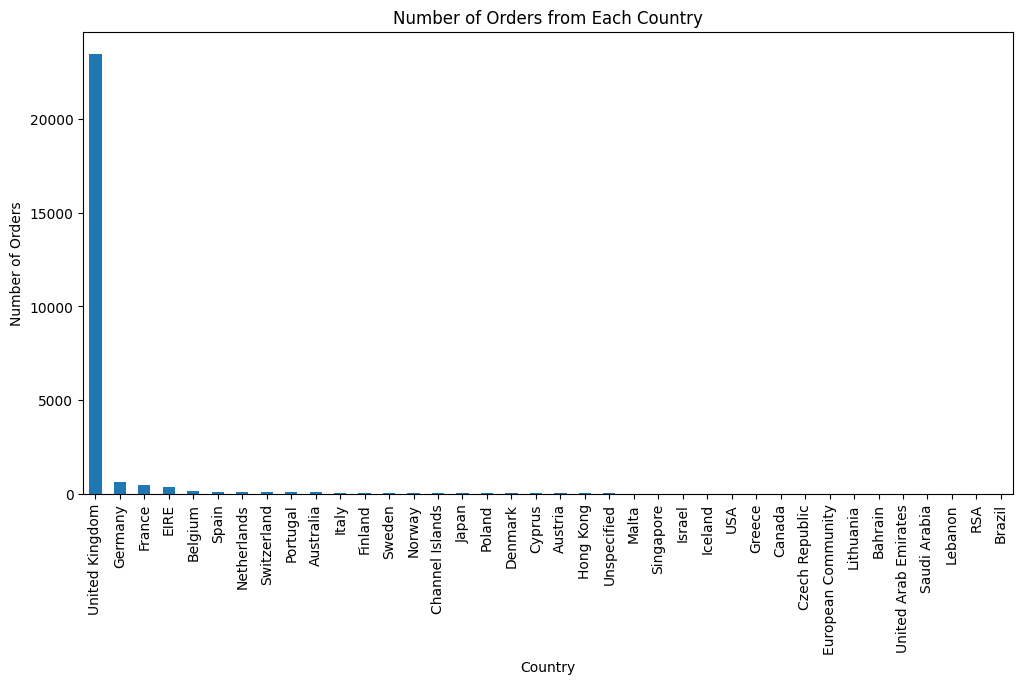

In [8]:
# Plotting
orders_per_country.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Number of Orders from Each Country')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)  # Rotates the labels on the x-axis for better readability
plt.show()

#### Normalizam datele sa fie doar din UK deoarece observam datele din restul tarilor sunt in cantitati prea mici pentru a fi relevante.

In [9]:
df = df.dropna(subset=['Description'])
df_uk = df[df['Country'] == 'United Kingdom']

In [10]:
clients_per_date = df_uk.groupby(df_uk['InvoiceDate'].dt.date)['CustomerID'].nunique()

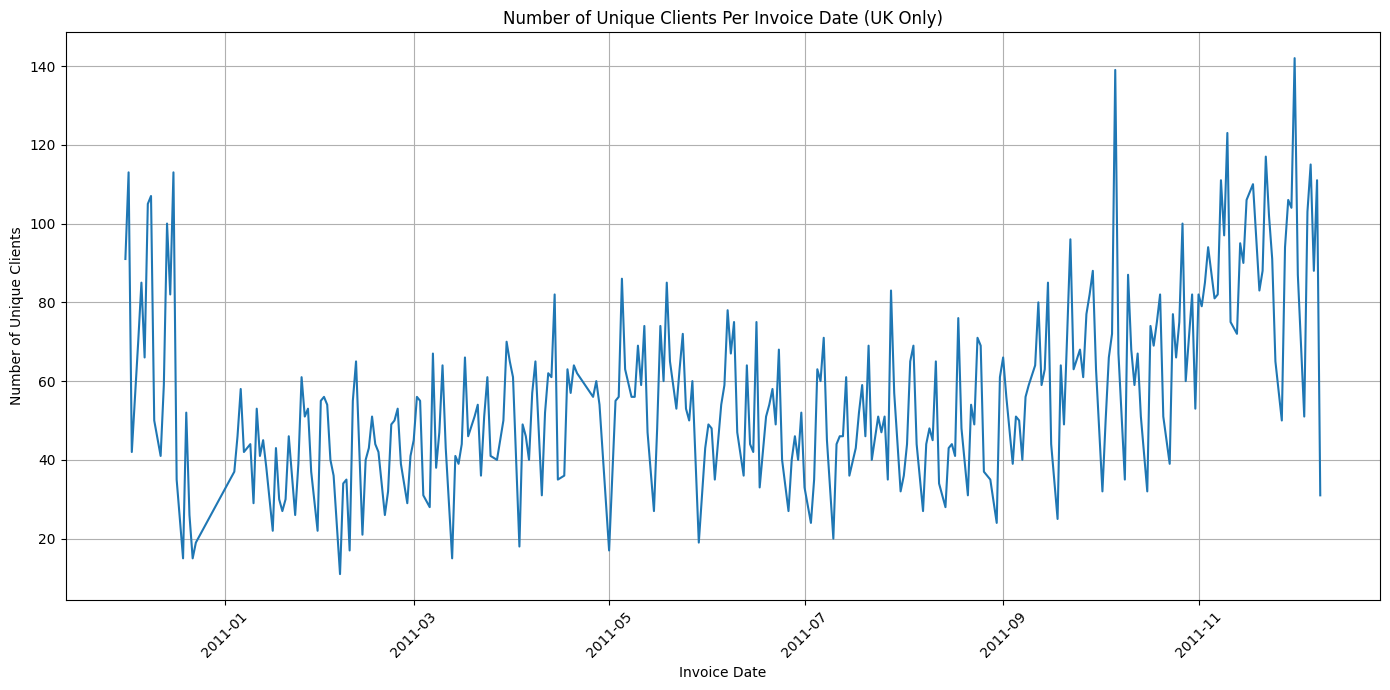

In [11]:
# Plotting
clients_per_date.plot(kind='line', figsize=(14, 7))  # Using a line plot
plt.title('Number of Unique Clients Per Invoice Date (UK Only)')
plt.xlabel('Invoice Date')
plt.ylabel('Number of Unique Clients')
plt.grid(True)
plt.xticks(rotation=45)  # Rotates the labels on the x-axis for better readability
plt.tight_layout()  # Adjusts plot parameters to give some padding
plt.show()

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import datetime as dt

### Pentru a putea prezice CLTV o sa folosesc metoda K-Means. O sa grupez clientii in 3 categorii.

### O sa folosesc 3 metrici de baza pentru asta: 
##### Recency: Cat de curand a fost facuta plata
##### Frequency: Cat de frecvent face plati
##### Monetary: In ce valoare sunt platile

In [13]:
# Calculate Recency, Frequency, Monetary for each customer
latest_date = df_uk['InvoiceDate'].max() + dt.timedelta(days=1)
rfm_table = df_uk.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'Revenue': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency',
                   'InvoiceNo': 'Frequency',
                   'Revenue': 'Monetary'})


In [14]:
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12747.0,2,11,4196.01
12748.0,1,224,29072.10
12749.0,4,8,3868.20
12820.0,3,4,942.34


In [15]:
# Scare date
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_table)

For n_clusters=2, the average silhouette score is: 0.8888938427608459


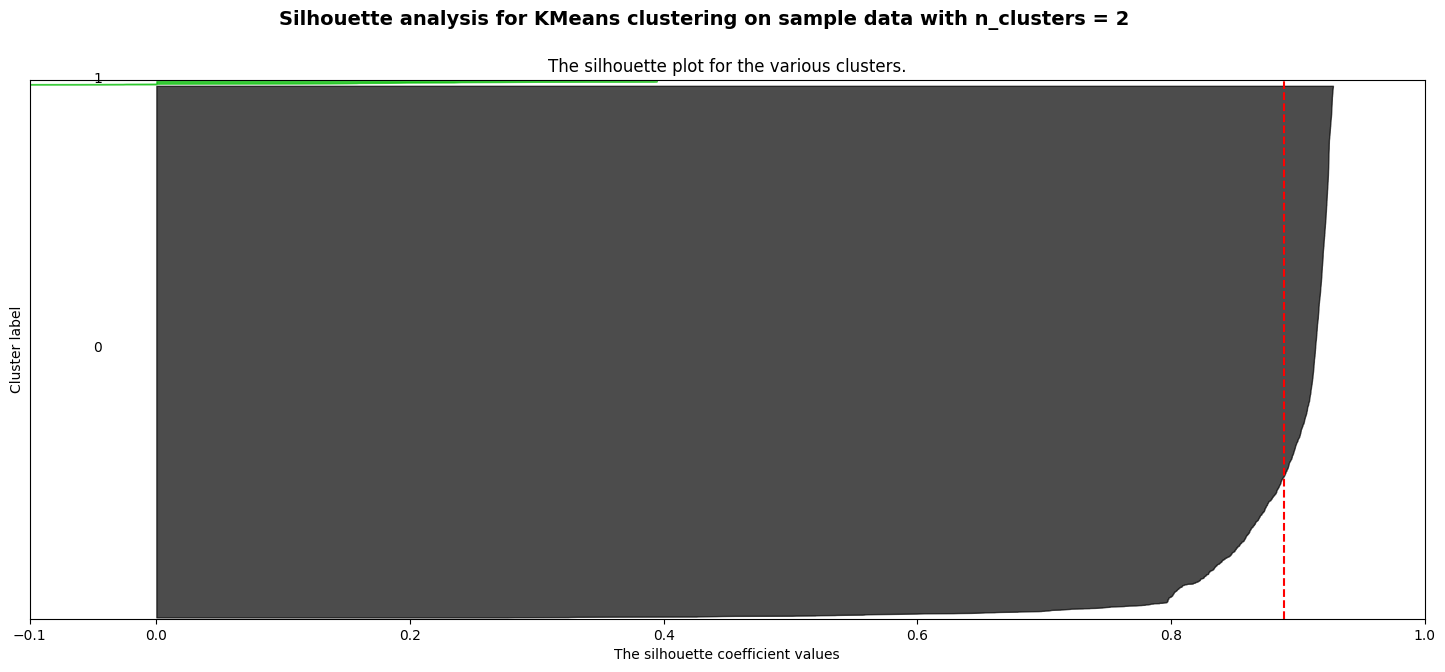

For n_clusters=3, the average silhouette score is: 0.5779886185381545


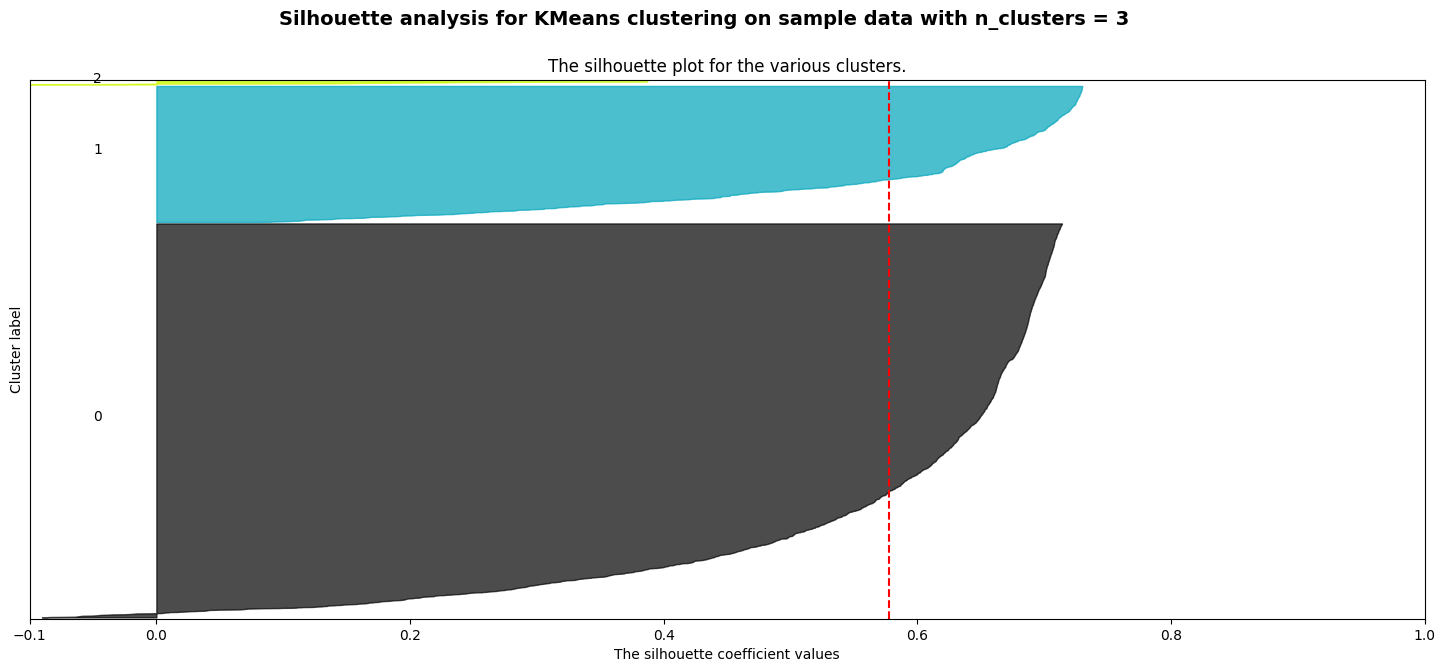

For n_clusters=4, the average silhouette score is: 0.6057766877807278


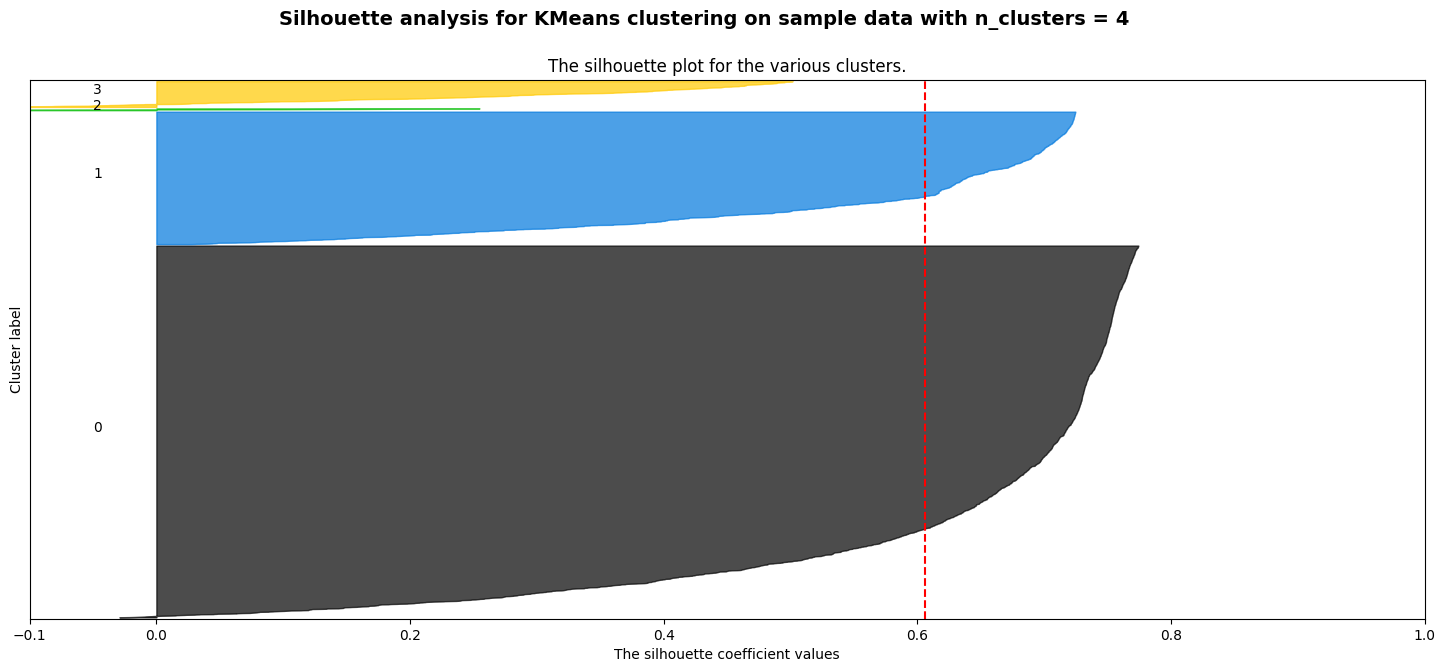

For n_clusters=5, the average silhouette score is: 0.5985702364252554


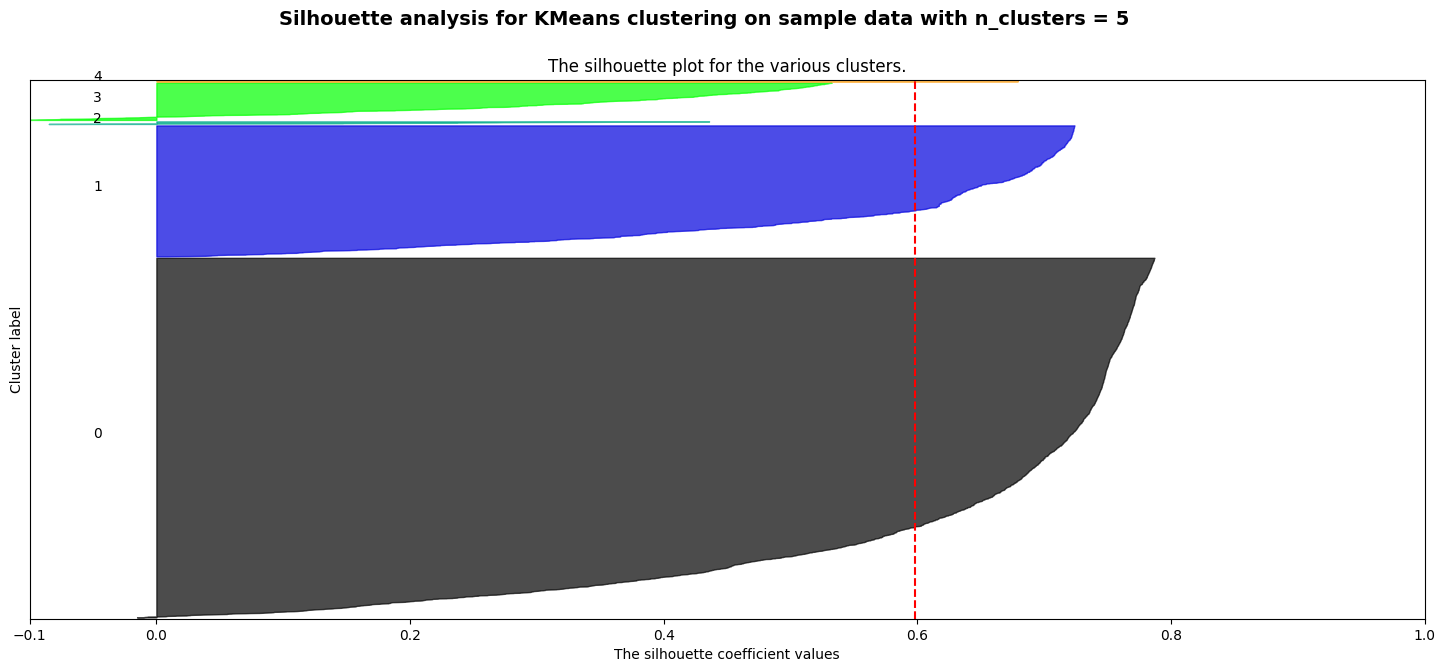

For n_clusters=6, the average silhouette score is: 0.5088558335111356


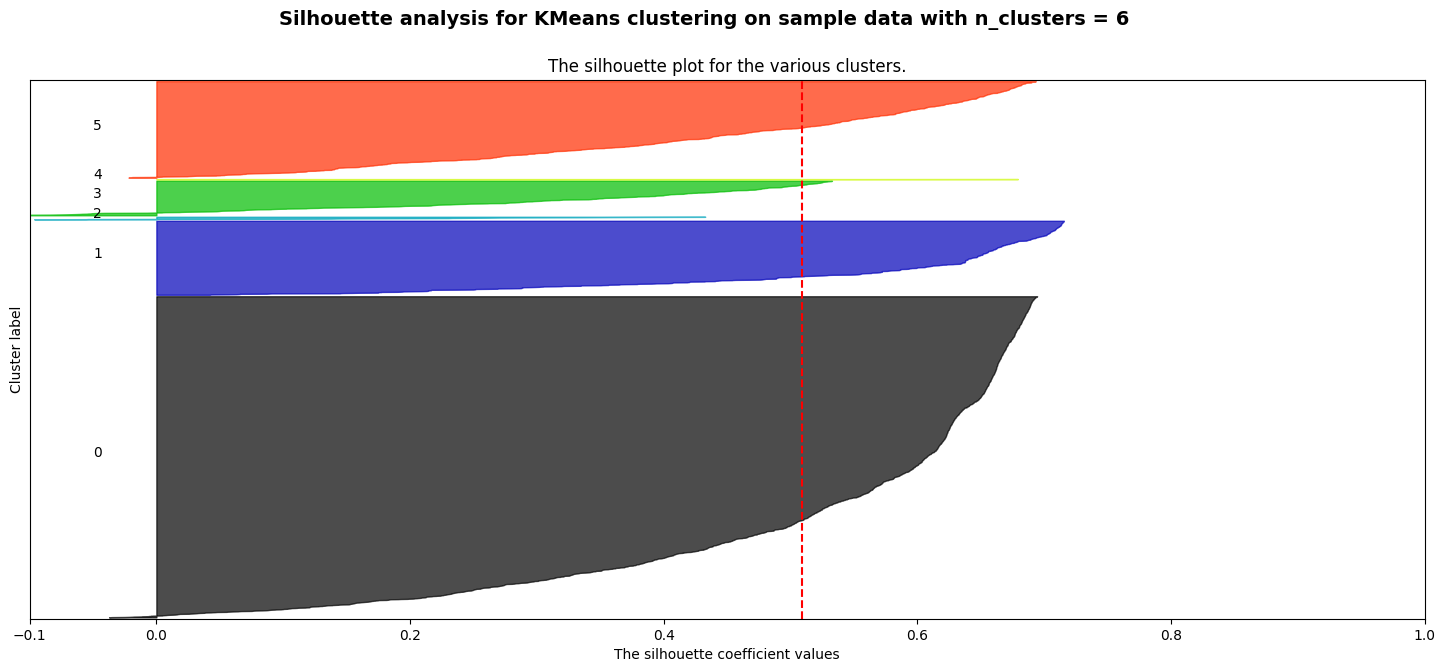

For n_clusters=7, the average silhouette score is: 0.5158269827374028


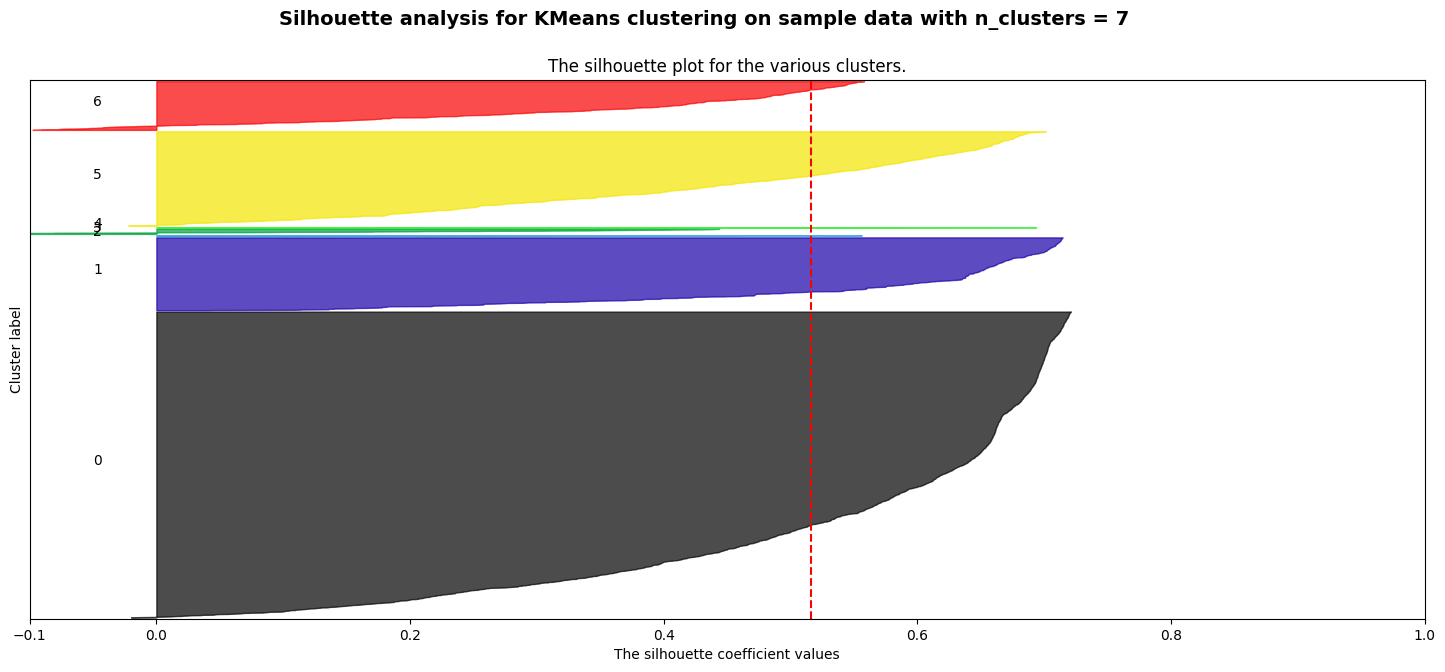

For n_clusters=8, the average silhouette score is: 0.4952306312561286


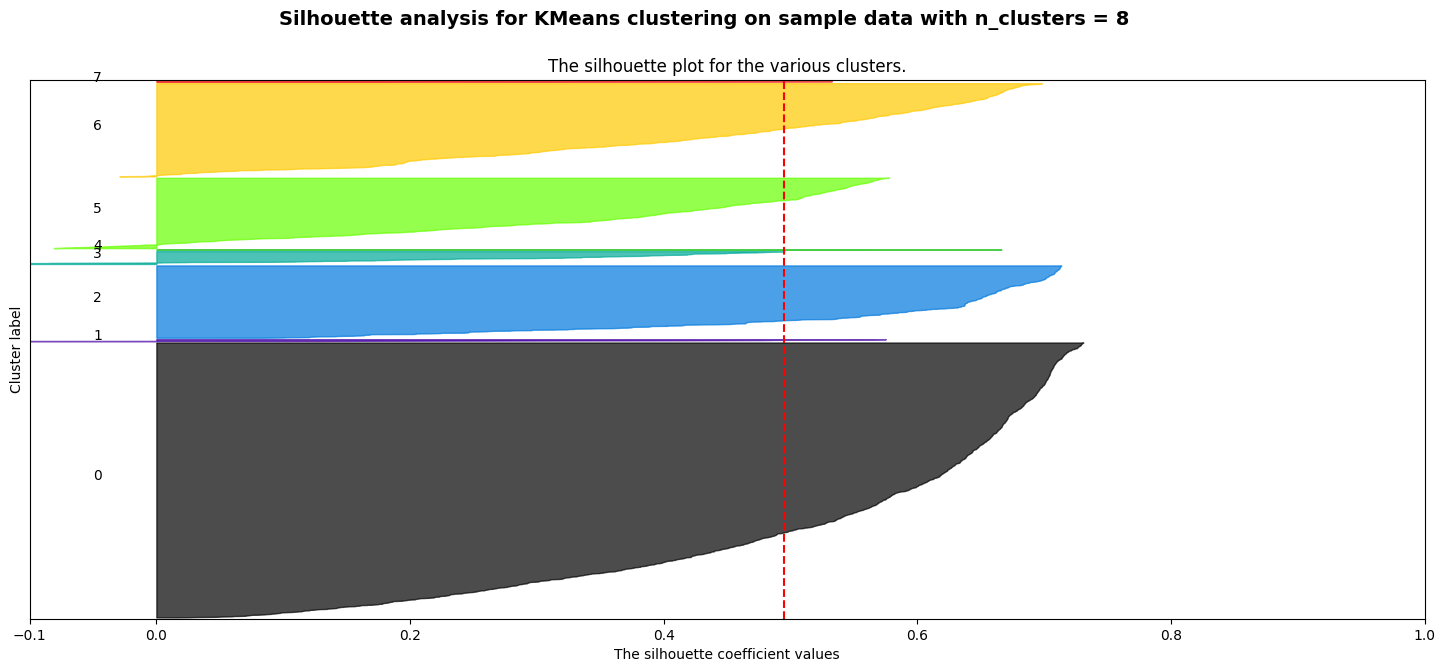

For n_clusters=9, the average silhouette score is: 0.45289249141987664


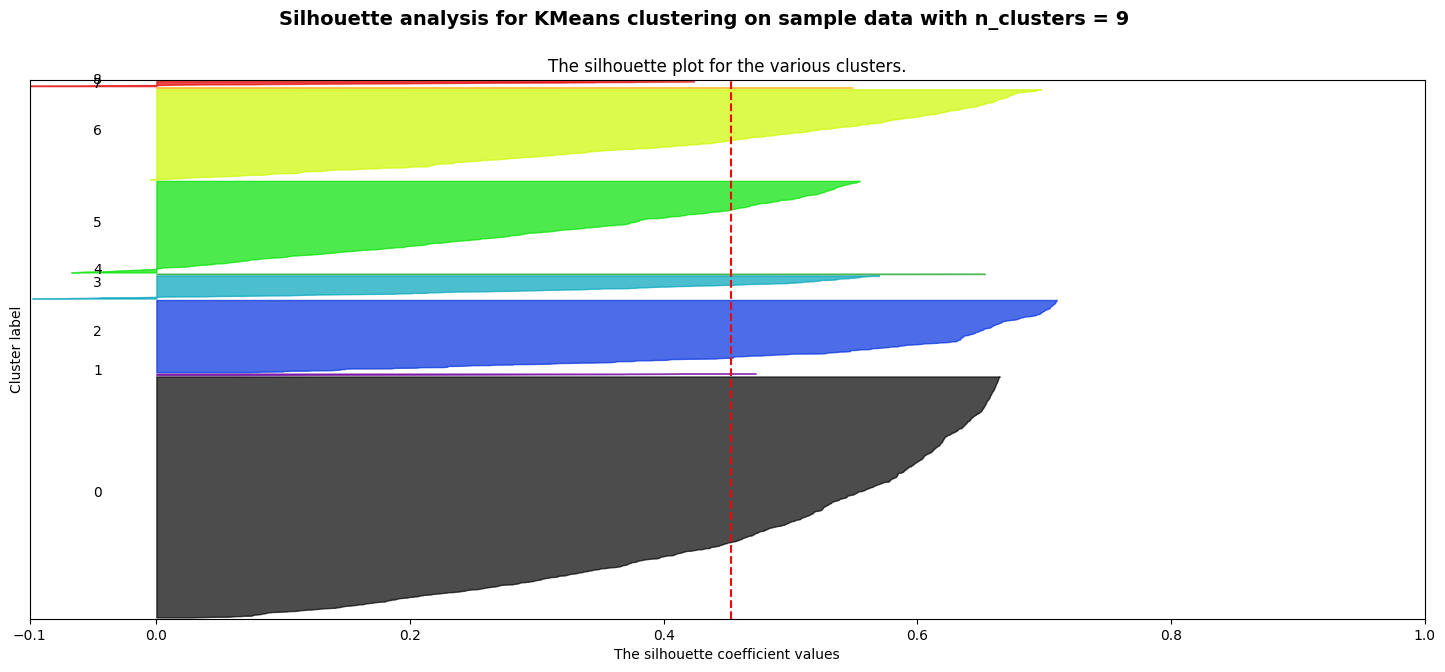

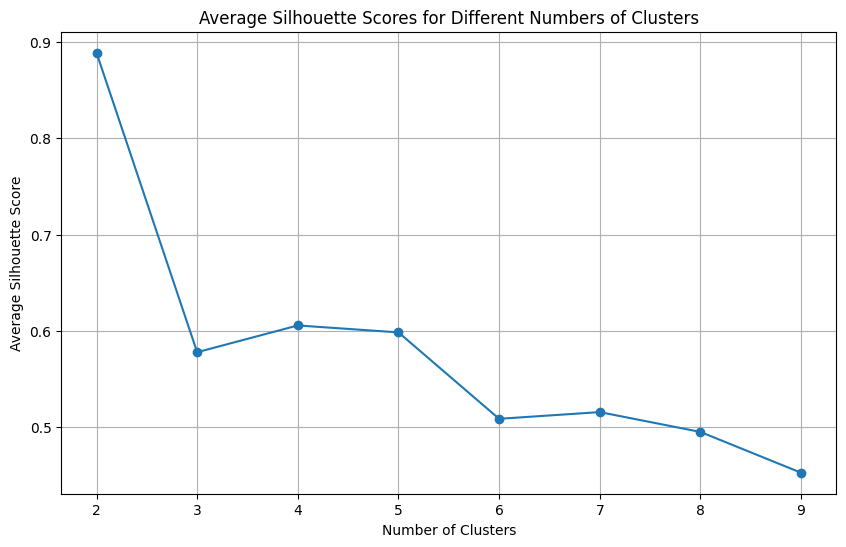

In [16]:
range_n_clusters = list(range(2, 10))  
silhouette_avg_scores = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(rfm_scaled)

    # Calc scor si adaug la lista
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"For n_clusters={num_clusters}, the average silhouette score is: {silhouette_avg}")

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(rfm_scaled) + (num_clusters + 1) * 10])

    # scor pt fiecare sample
    sample_silhouette_values = silhouette_samples(rfm_scaled, cluster_labels)

    y_lower = 10
    for i in range(num_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / num_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % num_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title('Average Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()


In [17]:
cluster_number = 3 # Chiar daca in graficul de mai sus 2 pare sa fie optim, o sa aleg 3 pentru a avea mai multe segmente

In [18]:
# K-Means
kmeans = KMeans(n_clusters=cluster_number, random_state=1) 
clusters = kmeans.fit_predict(rfm_scaled)
rfm_table['Cluster'] = clusters

In [19]:
rfm_table.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,2,0.00,0
12747.0,2,11,4196.01,2
12748.0,1,224,29072.10,1
12749.0,4,8,3868.20,2
12820.0,3,4,942.34,2


In [20]:
from sklearn.decomposition import PCA

In [21]:
# Aplic PCA sa reduc dimensiunile pentru vizualizare
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=1)
clusters = kmeans.fit_predict(rfm_scaled)

# Centroids pentru vizualizare
centroids = pca.transform(kmeans.cluster_centers_)

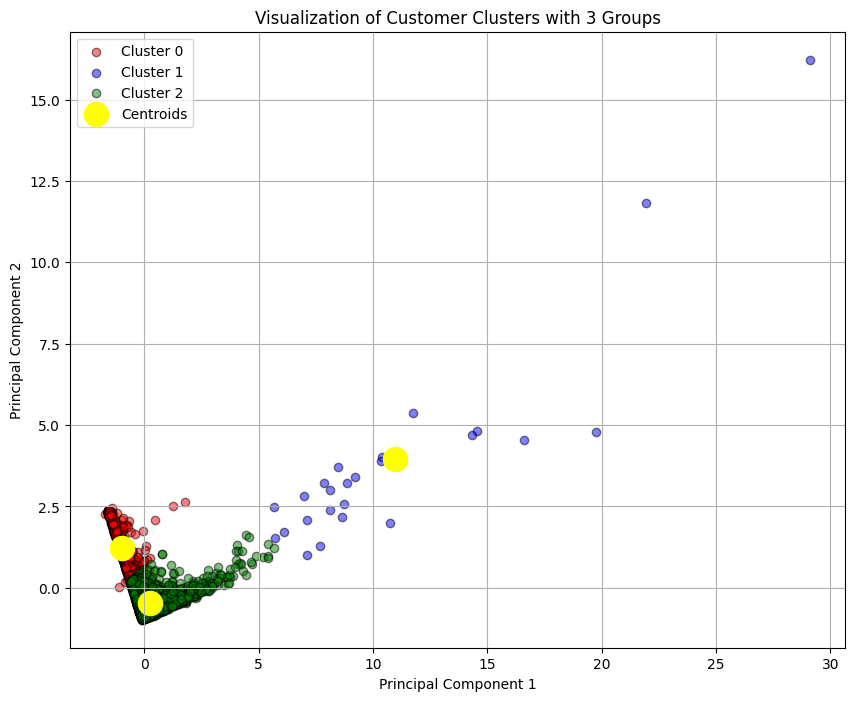

In [22]:
colors = ['red', 'blue', 'green']

plt.figure(figsize=(10, 8))

for i, color in enumerate(colors):
    x = rfm_pca[clusters == i, 0]
    y = rfm_pca[clusters == i, 1]
    plt.scatter(x, y, c=color, label=f'Cluster {i}', alpha=0.5, edgecolors='k')

plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', label='Centroids')

plt.title('Visualization of Customer Clusters with 3 Groups')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


# CLTV=Monetary×Frequency/Recency

In [23]:
# df_0 = rfm_table[rfm_table['Cluster'] == 0]
# df_1 = rfm_table[rfm_table['Cluster'] == 1]
# df_2 = rfm_table[rfm_table['Cluster'] == 2]

In [24]:
rfm_table['CLTV'] = rfm_table['Monetary'] * rfm_table['Frequency'] / rfm_table['Recency']

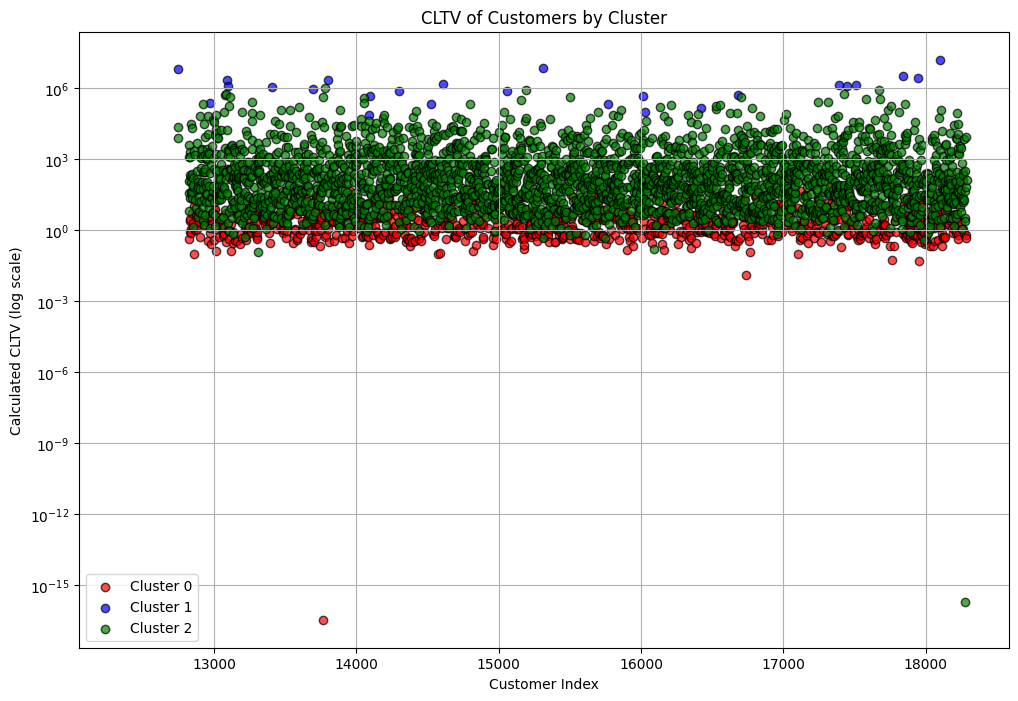

In [25]:
colors = ['red', 'blue', 'green']  

plt.figure(figsize=(12, 8))

for i, color in enumerate(colors):
    cluster_data = rfm_table[rfm_table['Cluster'] == i]
    plt.scatter(cluster_data.index, cluster_data['CLTV'], color=color, label=f'Cluster {i}', alpha=0.7, edgecolors='black')

plt.yscale('log')  # log scale
plt.title('CLTV of Customers by Cluster')
plt.xlabel('Customer Index')
plt.ylabel('Calculated CLTV (log scale)')
plt.legend()
plt.grid(True)
plt.show()


#### Putem Observa ca exita cativa 'Outliers' (probabil retururi de  produse).


In [26]:
cluster_counts = rfm_table['Cluster'].value_counts().sort_index()

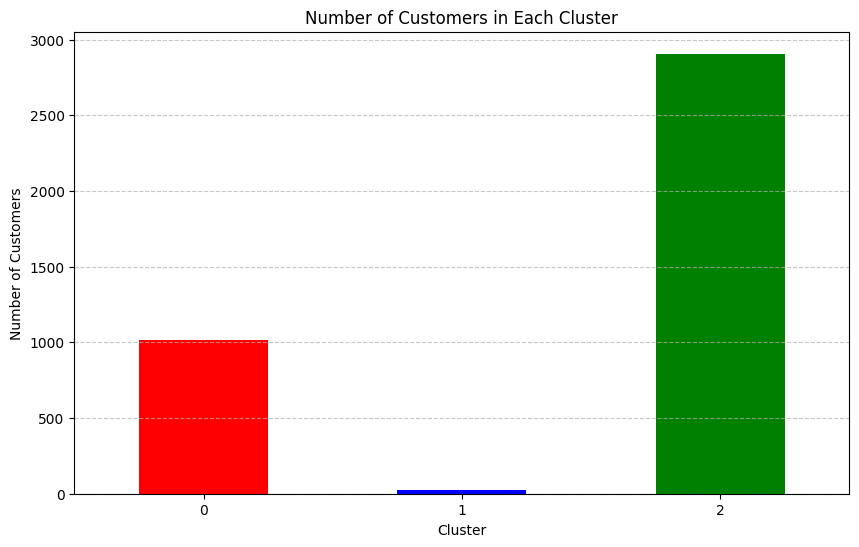

In [27]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Number of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)  # Keep the labels on the x-axis vertical for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Concluzie: Dupa ce am calculat CLTV doar pe UK putem oberva ca majoritatea clientilor se afla in clusterul 2. Clientii din clusterul 1 sunt cei mai valorosi cu un CLTV semnificativ mai mare. Iar cei din clusterul 0 au un CLTV mic, aproape de 0. Din toate aceste observatii putem prezice ce clienti vor avea o valoare mai mare pe parcursul relatiei noaste.